## Benchmarks

In [1]:
import cupy as cp 

forces_beta = cp.ElementwiseKernel(
    'raw float64 S, raw float64 I, float64 beta, float64 gamma, float64 D, uint32 Lx, uint32 Ly',
    'float64 fS, float64 fI',
    '''
    int x = i % Lx;
    int y = (int) i/Lx;

    fS = -beta*S[i]*I[i];
    fI = beta*S[i]*I[i] - gamma*I[i] + D*(I[(x+1)%Lx + Lx*y] + I[(x-1+Lx)%Lx + Lx*y] + I[x + Lx*((y+1)%Ly)] + I[x + Lx*((y-1+Ly)%Ly)] - 4*I[i]);
    ''',
    'forces_beta')

forces_beta2 = cp.ElementwiseKernel(
    'raw float32 S, raw float32 I, float32 beta, float32 gamma, float32 D, uint32 Lx, uint32 Ly',
    'float32 fS, float32 fI',
    '''
    int x = i % Lx;
    int y = (int) i/Lx;

    fS = -beta*S[i]*I[i];
    fI = beta*S[i]*I[i] - gamma*I[i] + D*(I[(x+1)%Lx + Lx*y] + I[(x-1+Lx)%Lx + Lx*y] + I[x + Lx*((y+1)%Ly)] + I[x + Lx*((y-1+Ly)%Ly)] - 4*I[i]);
    ''',
    'forces_beta')

In [37]:
#float64
Lx = 2**10
Ly = 2**8
S = cp.ones((Ly,Lx))
I = cp.zeros((Ly,Lx))
I[:,0] = 1
S[:,0] = 0
fS = cp.zeros((Ly,Lx))
fI = cp.zeros((Ly,Lx))
beta = 1
gamma = .2
D = 1

In [67]:
def set_tilded_initial_conditions(S,I,m = 0):
    Ly,Lx = S.shape
    n = int(cp.round(m*(Ly-2)))
    dn = 1/m
    j = 0
    for i in range(1,Ly-1):
        I[i,j] = 1 
        S[i,j] = 0 
        if i >= (j+1)*dn:
            j += 1
    I[0,0] = 1
    S[0,0] = 0
    I[-1,n-1] = 1
    S[-1,n-1] = 0


In [70]:
I = cp.zeros((16,16))
S = cp.ones((16,16))
set_tilded_initial_conditions(S,I,m = .4)

In [38]:
for i in range(1,Ly):
    I[i,:] = cp.roll(I[i,:],i-1)
    S[i,:] = cp.roll(S[i,:],i-1)
    S[i,:i-1] = 0 
I[-1,:] = cp.roll(I[0,:],Ly-3)

In [67]:
#float32
Lx = 2**10
Ly = 2**10
S2 = cp.ones((Ly,Lx),cp.float32)
I2 = cp.zeros((Ly,Lx),cp.float32)
I2[:,0] = 1
S2[:,0] = 0

fS2 = cp.zeros((Ly,Lx),cp.float32)
fI2 = cp.zeros((Ly,Lx),cp.float32)
beta = 1
gamma = .2
D = 1


In [32]:
print(benchmark(forces_beta2,(S,I,beta,gamma,D,Lx,Ly,fS,fI)))

forces_beta         :    CPU:   24.881 us   +/- 9.581 (min:   14.000 / max:  152.100) us     GPU-0: 4684.275 us   +/-10.617 (min: 4664.320 / max: 4807.680) us


In [40]:
for _ in range(100):
    forces_beta(S,I,beta,gamma,D,Lx,Ly,fS,fI)
    S += .05*fS
    I += .05*fI
    I[0,:-Ly + 3] = I[-2,Ly - 3:]
    S[0,:-Ly + 3] = S[-2,Ly - 3:]
    I[-1,Ly - 3:] = I[1,:-Ly + 3]
    S[-1,Ly - 3:] = S[1,:-Ly + 3]
    I[:,-1] = S[:,-1] = 0

In [69]:
for _ in range(10000):
    forces_beta2(S2,I2,beta,gamma,D,Lx,Ly,fS2,fI2)
    S2 += .05*fS2
    I2 += .05*fI2
    I2[:,-1] = S2[:,-1] = 0

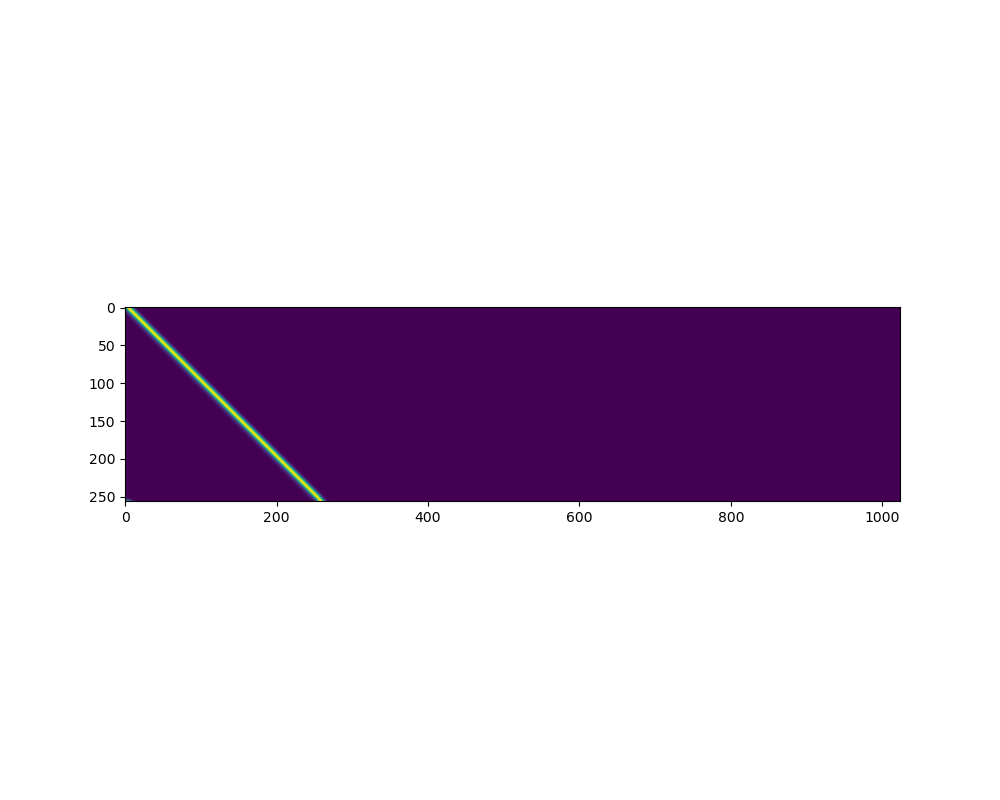

In [41]:
%matplotlib widget

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.imshow(cp.asnumpy(I),interpolation=None)
plt.show()

In [1]:
from system import *

In [2]:
Lx = 2**13
Ly = 2**10
m = .1
s = System(Lx,Ly)
s.gamma = .2
s.D = 1
s.beta = 1

In [3]:
s.set_tilded_initial_conditions(m)

In [4]:
for i in range(1000):
    s.update()
    s.rigid_x()
    s.tilded_y(m)

### update() vs update2()

In [1]:
from system import *

In [20]:
Lx = 2**14
Ly = 2**10

In [21]:
s = System(Lx,Ly)
s.gamma = .2
s.D = 1
s.set_dic_beta(p = .5)
s.set_plane_initial_conditions()

In [22]:
s2 = System(Lx,Ly)
s2.gamma = .2
s2.D = 1
s2.set_dic_beta(p = .5)
s2.set_plane_initial_conditions()

In [17]:
import numpy as np
ucm = cp.array([])
ucm2 = cp.array([])

In [23]:
for _ in range(10000):
    s.update()
    s.rigid_x()

In [24]:
for _ in range(10000):
    s2.update2(m = .5)
    s2.rigid_x()

In [25]:
for _ in range(10000):
    s.update()
    s.rigid_x()
    s2.update2(m=.5)
    s2.rigid_x()
    ucm = cp.append(ucm,s.u_cm())
    ucm2 = cp.append(ucm2,s2.u_cm())
ucm = cp.asnumpy(ucm)
ucm2 = cp.asnumpy(ucm2)


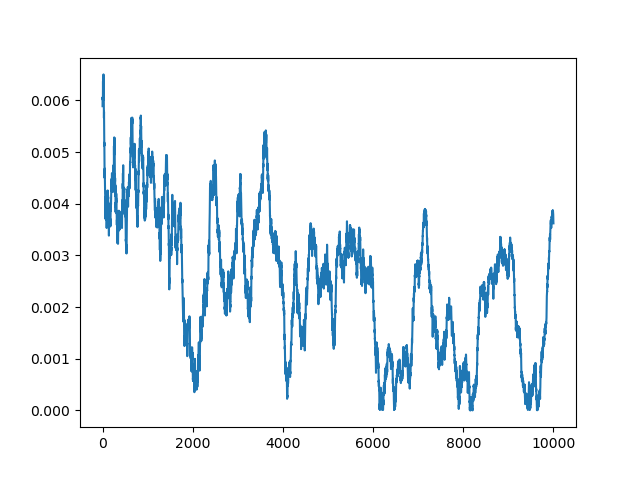

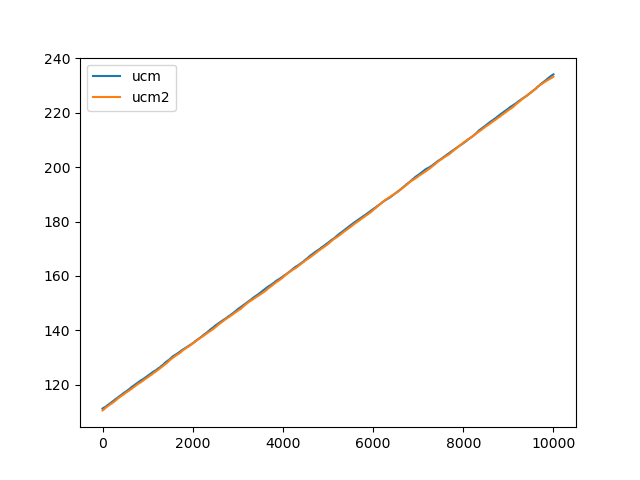

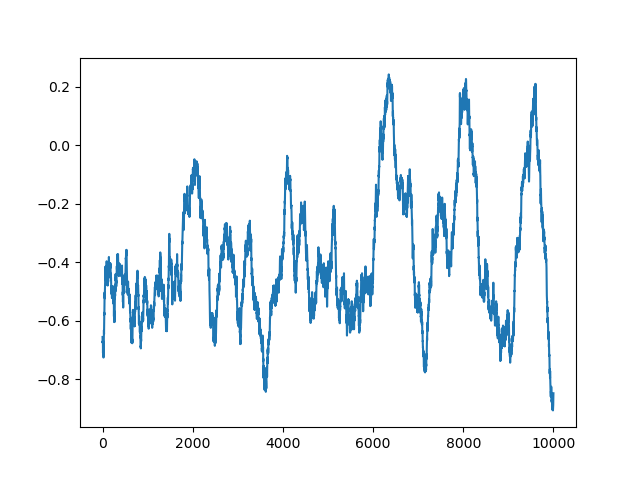

In [26]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.figure()

plt.plot(ucm,label='ucm')
plt.plot(ucm2,label='ucm2')
plt.legend()


plt.figure()
plt.plot(ucm2-ucm)

plt.figure()
plt.plot(np.abs(ucm2-ucm)/ucm)

plt.show()

In [11]:
s.u_cm()

array(111.06835938)

In [12]:
s2.u_cm()

array(110.83105469)